## Import data

In [1]:
import pandas as pd # pyright: ignore[reportMissingModuleSource]

emg_cols = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8']
GESTURE_COL = "CurrentGestures"
THRESHOLD_COL = "Threshold"

df = pd.read_csv("../data3.csv", sep=";")
print(df.shape)  # dimensions
print(df.info())  # types and missing values

(138004, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138004 entries, 0 to 138003
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Threshold        138004 non-null  object
 1   EMG1             138004 non-null  int64 
 2   EMG2             138004 non-null  int64 
 3   EMG3             138004 non-null  int64 
 4   EMG4             138004 non-null  int64 
 5   EMG5             138004 non-null  int64 
 6   EMG6             138004 non-null  int64 
 7   EMG7             138004 non-null  int64 
 8   EMG8             138004 non-null  int64 
 9   Framecount       138004 non-null  int64 
 10  CurrentGestures  138004 non-null  object
 11  SessionID        138004 non-null  object
 12  Timestamp        138004 non-null  object
dtypes: int64(9), object(4)
memory usage: 13.7+ MB
None


## Clean data
### Manage missing data

In [2]:
df = df.drop_duplicates()  # remove duplicate rows
df = df.dropna() # remove rows with missing values

### Standardize data

In [3]:
from sklearn.preprocessing import StandardScaler # pyright: ignore[reportMissingModuleSource]

# Standardization
scaler = StandardScaler()
standard_data = scaler.fit_transform(df[emg_cols])

### Encode label

In [4]:
from sklearn.preprocessing import LabelEncoder # pyright: ignore[reportMissingModuleSource]

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df[GESTURE_COL])

print("\nEncoded labels:")
print(df[['label', GESTURE_COL]].drop_duplicates())


Encoded labels:
        label CurrentGestures
0           0            fist
27026       1           pinch
53852       3      wrist-back
80744       4   wrist-forward
106544      2            rest


### Split data

In [5]:
from sklearn.model_selection import train_test_split

# Use the cleaned and prepared dataframe from previous cells
# Separate features (X) and labels (y)
X = standard_data
y = df['label']

# 3. Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Evaluation

In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_val, y_val):
    # Evaluate on validation set
    y_pred = model.predict(X_val)
    print("Validation accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
	
    # Cross-validation
    scores = cross_val_score(model, X_val, y_val, cv=5)
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())


    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    # ROC Curve
    y_val_bin = label_binarize(y_val, classes=model.classes_)
    probs_full = model.predict_proba(X_val)

    plt.figure()
    for i in range(y_val_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs_full[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend()
    plt.show()

## Artificial Neural Network

In [7]:
from sklearn.ensemble import RandomForestClassifier

def create_rf_model(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

## Hyperparameter optimization

c:\Users\stud\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-09-11 11:59:04,280] A new study created in memory with name: no-name-461a5744-3c83-46c0-9efb-53cc301146f3
[I 2025-09-11 11:59:07,346] Trial 0 finished with value: 0.7558746111623015 and parameters: {'n_estimators': 156, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7558746111623015.
[I 2025-09-11 11:59:12,452] Trial 1 finished with value: 0.7699736849600815 and parameters: {'n_estimators': 232, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7699736849600815.
[I 2025-09-11 11:59:14,583] Trial 2 finished with value: 0.6926668088892729 and parameters: {'n_estimators': 158, 'max_depth': 5, 'min_samples_split': 10,


===== Top 5 trials =====

       value  params_n_estimators  params_max_depth  params_min_samples_split  \
11  0.771827                  116                20                         3   
12  0.771744                  107                20                         2   
14  0.771744                  107                20                         3   
9   0.771651                  147                20                         2   
5   0.770916                  146                17                         5   

    params_min_samples_leaf  
11                        3  
12                        4  
14                        4  
9                         3  
5                         2  


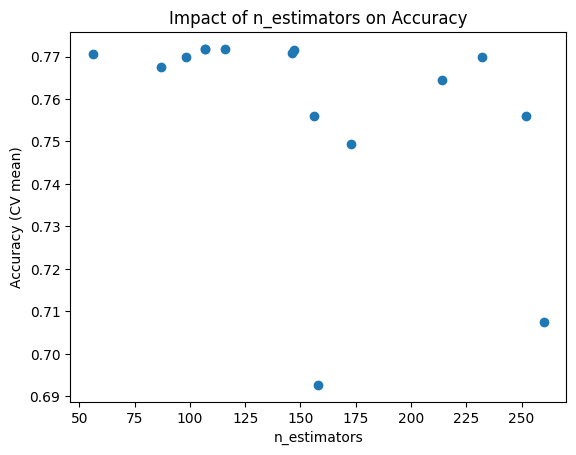

In [8]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    rf = create_rf_model(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

df_results = study.trials_dataframe()
df_sorted = df_results.sort_values('value', ascending=False)
print("\n===== Top 5 trials =====\n")
print(df_sorted[['value', 'params_n_estimators', 'params_max_depth', 'params_min_samples_split', 'params_min_samples_leaf']].head())

plt.scatter(df_results['params_n_estimators'], df_results['value'])
plt.xlabel("n_estimators")
plt.ylabel("Accuracy (CV mean)")
plt.title("Impact of n_estimators on Accuracy")
plt.show()

### Get best parameters

In [9]:
best_params = study.best_trial.params
print("Best parameters:", best_params)

Best parameters: {'n_estimators': 116, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3}


### Train final model

Training improved Random Forest...
Training completed!

=== IMPROVED RANDOM FOREST RESULTS ===
Validation accuracy: 0.7773537510265205
              precision    recall  f1-score   support

           0       0.67      0.64      0.65      3991
           1       0.63      0.67      0.65      4038
           2       0.86      0.84      0.85      4731
           3       0.84      0.85      0.84      4067
           4       0.88      0.89      0.88      3874

    accuracy                           0.78     20701
   macro avg       0.78      0.78      0.78     20701
weighted avg       0.78      0.78      0.78     20701

Cross-validation scores: [0.76672301 0.76207729 0.76328502 0.77463768 0.76618357]
Mean accuracy: 0.7665813177288037


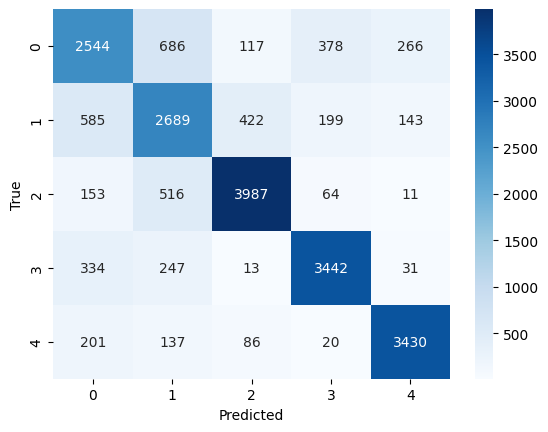

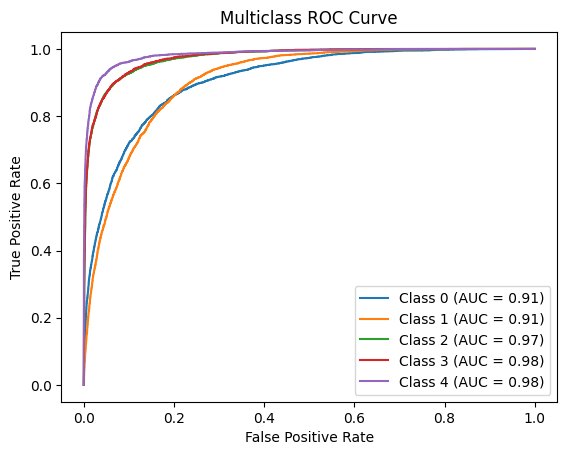


============== Test Accuracy: 0.7714120090816868 ==============
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      4093
           1       0.63      0.67      0.65      4140
           2       0.85      0.84      0.84      4659
           3       0.82      0.83      0.82      3960
           4       0.88      0.88      0.88      3849

    accuracy                           0.77     20701
   macro avg       0.77      0.77      0.77     20701
weighted avg       0.77      0.77      0.77     20701



In [10]:
best_rf = create_rf_model(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
)

print("Training improved Random Forest...")
best_rf.fit(X_train, y_train)
print("Training completed!")

print("\n=== IMPROVED RANDOM FOREST RESULTS ===")
evaluate_model(best_rf, X_val, y_val)

y_pred = best_rf.predict(X_test)
print("\n============== Test Accuracy:", accuracy_score(y_test, y_pred), "==============")
print(classification_report(y_test, y_pred))


## Model export

In [11]:
import json
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime

FEATURE_NAMES = emg_cols
CLASS_NAMES = encoder.classes_.tolist()

df = pd.read_csv("../data.csv", sep=";")
df = df.drop_duplicates()
df = df.dropna()

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['gesture'])
Y = df['label']
X = df[emg_cols]

X_train, X_eval, y_train, y_eval = train_test_split(X, Y, test_size=0.3, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", create_rf_model(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_eval)

metrics = {
    "accuracy": float(accuracy_score(y_eval, y_pred)),
    "report": classification_report(y_eval, y_pred, target_names=CLASS_NAMES, output_dict=True),
}

timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
model_dir = f"../models/gesture_recognition_RF_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(pipe, f"{model_dir}/pipeline.joblib")

config = {
    "feature_names": FEATURE_NAMES,
    "class_names": CLASS_NAMES,
    "top_k": 2,
    "abstain_threshold": 0.6,
    "random_state": 42,
    "library": {"sklearn": ">=1.2"},
}
with open(f"{model_dir}/config.json", "w") as f:
    json.dump(config, f, indent=2)

with open(f"{model_dir}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Model exported to:", model_dir)


KeyError: 'gesture'